## 1. Install Dependencies

In [1]:
pip install tensorflow opencv-python numpy matplotlib scikit-learn Pillow tqdm

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     --------------------- ------------------ 30.7/57.6 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 764.0 kB/s eta 0:00:00
     ---------------------------------------- 0.0/160.8 kB ? eta -:--:--
     --------- ----------------------------- 41.0/160.8 kB 1.9 MB/s eta 0:00:01
     -------------------------------------- 160.8/160.8 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.6 MB 3.2 MB/s eta 0:00:13
   ---------------------------------------- 0.2/38.6 MB 2.3 MB/s eta 0:00:17
   ---------------------------------------- 0.3/38.6 MB 2.1 MB/s eta 0:00:19
   ---------------------------------------- 0.4/38.6 MB 2.5 MB/s eta 0:00:16
    -

In [2]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
print(tf.version)

<module 'tensorflow._api.v2.version' from 'C:\\Users\\harsh\\anaconda3\\envs\\tensorflow\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


In [4]:
#pip list

In [5]:
# For using GPUS
gpus = tf.config.experimental.list_physical_devices('GPU') # Listing GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

## 2. Load the Data

In [6]:
import numpy as np
import cv2
from struct import unpack
from tqdm import tqdm

#### Removing corrupt images

In [7]:
# Your root directory containing subdirectories for each class
# root_img = 'Dataset'

# marker_mapping = {
#     0xffd8: "Start of Image",
#     0xffe0: "Application Default Header",
#     0xffdb: "Quantization Table",
#     0xffc0: "Start of Frame",
#     0xffc4: "Define Huffman Table",
#     0xffda: "Start of Scan",
#     0xffd9: "End of Image"
# }

# class JPEG:
#     def __init__(self, image_file):
#         with open(image_file, 'rb') as f:
#             self.img_data = f.read()
    
#     def decode(self):
#         data = self.img_data
#         while True:
#             marker, = unpack(">H", data[0:2])
#             if marker == 0xffd8:
#                 data = data[2:]
#             elif marker == 0xffd9:
#                 return
#             elif marker == 0xffda:
#                 data = data[-2:]
#             else:
#                 lenchunk, = unpack(">H", data[2:4])
#                 data = data[2 + lenchunk:]            
#             if len(data) == 0:
#                 break    

# # JPEG processing loop
# bads = []

# for class_dir in os.listdir(root_img):
#     class_path = os.path.join(root_img, class_dir)
#     if os.path.isdir(class_path):
#         for img in tqdm(os.listdir(class_path)):
#             image_path = os.path.join(class_path, img)
#             jpeg_image = JPEG(image_path)
#             try:
#                 jpeg_image.decode()
#             except:
#                 bads.append((img, class_dir)) 

# # Function to remove bad images
# def remove_bad_images(bads):
#     for name, class_dir in bads:
#         os.remove(os.path.join(root_img, class_dir, name))

# # Remove bad images for each class
# for class_dir in ['benign', 'malignant']:
#     remove_bad_images([(name, class_dir) for name, dir_ in bads if dir_ == class_dir])

In [8]:
data = tf.keras.utils.image_dataset_from_directory('Dataset',shuffle=True)

Found 9999 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

## 3. Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Set the path to your dataset directory
data_directory = 'Dataset'

# Create an ImageDataGenerator with augmentation configurations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an image dataset without data augmentation for validation and test sets
data_no_augmentation = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    image_size=(224, 224),
    batch_size=64,
    label_mode='binary',  # or 'categorical' if you have more than two classes
    shuffle=True,
    seed=42,
    validation_split=0.1,  # Using 10% for validation
    subset='validation'
)

# Split the data into validation and test sets
val_size = 1000  # Adjust as needed
test_size = 1000  # Adjust as needed
val = data_no_augmentation.take(val_size)
test = data_no_augmentation.skip(val_size).take(test_size)

# Create an image dataset with data augmentation for the training set
train_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    image_size=(224, 224),
    batch_size=64,
    label_mode='binary',  # or 'categorical' if you have more than two classes
    shuffle=True,
    seed=42,
    validation_split=0.1,  # Using 10% for validation
    subset='training'
)

# Apply data augmentation to the training set within the TensorFlow pipeline
augmented_data = train_data.map(lambda x, y: (tf.image.random_flip_left_right(x), y))

# Normalize pixel values to the range [0, 1]
augmented_data_normalized = augmented_data.map(lambda x, y: (x / 255, y))

# Now, 'augmented_data_normalized' contains the augmented and normalized images for the training set


Found 9999 files belonging to 2 classes.
Using 999 files for validation.
Found 9999 files belonging to 2 classes.
Using 9000 files for training.


In [12]:
print(f"Training Dataset size :{augmented_data}")
print(f"Validating Dataset size :{val}")
print(f"Testing Dataset size :{test}")

Training Dataset size :<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Validating Dataset size :<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Testing Dataset size :<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [13]:
# Get a batch from the Iterator
batch = augmented_data_normalized.as_numpy_iterator().next()

In [14]:
#Images represnted as Np array
batch[0].shape

(64, 224, 224, 3)

In [15]:
#Class 1 : Malignant
#Class 0 : Benign
batch[1]

array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

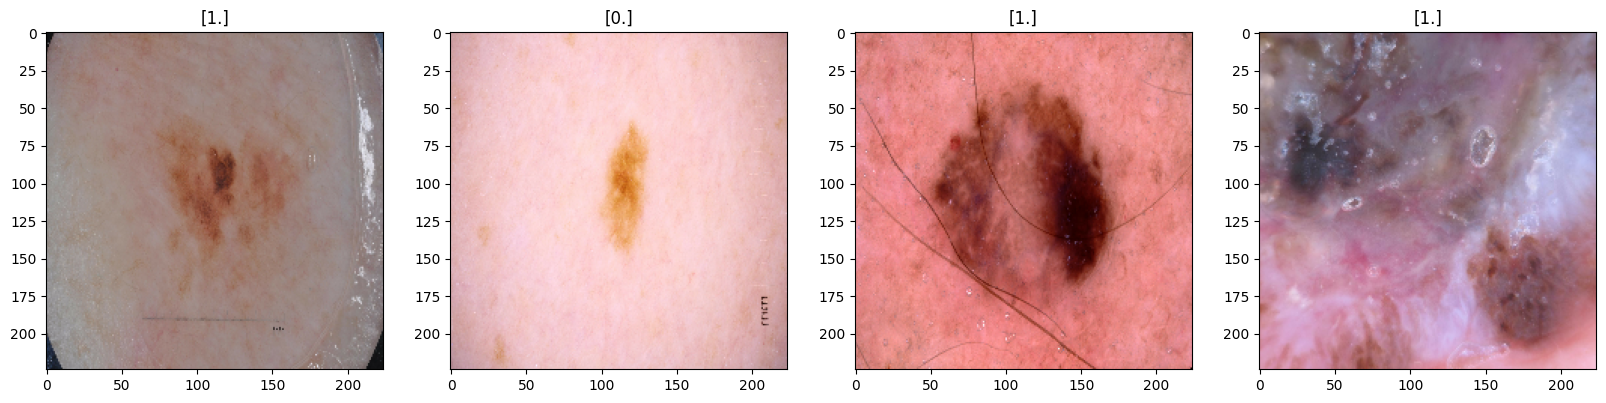

In [16]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## 4. Building the model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16

In [18]:
# Load pre-trained VGG16 model with weights from ImageNet (you can choose other models)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom head for your specific task (classification in this example)
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Adjust the number of units based on your task

# Combine the base model and custom head
model = Model(inputs=base_model.input, outputs=x)

58889256/58889256 [==============================] - 25s 0us/step


In [19]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# model.compile(optimizer=SGD(learning_rate=0.01), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) --> Apply this if Overfitting

In [20]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 5. Training the Model

In [22]:
logdir = "logs"

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [24]:
train_data = augmented_data_normalized

In [25]:
with tf.device('/GPU:0'):
    hist = model.fit(train_data, epochs=20, validation_data=val, callbacks=[tensorboard_callback]) 

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block1_conv2/Relu' defined at (most recent call last):
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\harsh\AppData\Local\Temp\ipykernel_3620\52224089.py", line 2, in <module>
      hist = model.fit(train_data, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\harsh\anaconda3\envs\tensorflow\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/block1_conv2/Relu'
OOM when allocating tensor with shape[64,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block1_conv2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1632]

## 6. Plotting Performance

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


## 7. Evaluating the Performance

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# Evaluate the model
Y_pred = model.predict(test)
y_pred = np.round(Y_pred)

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
y_true_list = []
y_pred_prob_list = []

# Iterate over batches
for batch in test.as_numpy_iterator():
    X, y = batch
    # yhat = model.predict(X).flatten()  # Flatten to get a 1D array
    yhat = model.predict(X, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0).flatten()
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    # Append true labels and predicted probabilities to the lists
    y_true_list.extend(y)
    y_pred_prob_list.extend(yhat)

# Convert probabilities to binary labels using a threshold (e.g., 0.5)
y_pred_list = (np.array(y_pred_prob_list) > 0.5).astype(int)

# Print classification report and confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_list, y_pred_list))
print("\nClassification Report:")
print(classification_report(y_true_list, y_pred_list))

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

## 8. Testing the Model

In [ ]:
img = cv2.imread('Testing/benign3.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
resize.shape

In [ ]:
np.expand_dims(resize, 0).shape

In [ ]:
yhat = model.predict(np.expand_dims(resize/255 , 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5 :
    print(f'Malignant')
elif yhat < 0.5 :
    print(f'Benign')

## 9. Saving the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','test.keras'))

In [ ]:
new_model = load_model('models/skin_cnn_4_79%.keras')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))